<a href="https://colab.research.google.com/github/Roudranil/Bayesian-analysis-of-efficacy-of-the-ChAdOx1-nCoV-19-AZD1222-vaccine/blob/main/covid_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from IPython.display import Latex

import numpy as np
import arviz as az

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import scipy
from scipy import stats
from scipy.stats.mstats import mquantiles
from scipy.stats import gaussian_kde as gkde

import theano.tensor as tt

import pymc3 as pm

In [ ]:
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.grid'] = True
az.rcParams['stats.hdi_prob'] = 0.95
%config InlineBackend.figure_format = 'retina'
az.style.use(["arviz-darkgrid", "arviz-orangish"])
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['font.size'] = 14
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
warnings.simplefilter("ignore", UserWarning)

# Medium article second try

In [ ]:
vachkin_model = pm.Model()

In [ ]:
v_case = 8
c_case = 162

In [ ]:
with pm.Model():
    v_irr = pm.Beta("v_irr", alpha=8, beta=18198-8)
    c_irr = pm.Beta("c_irr", alpha=162, beta=18325-162)
    ve = pm.Deterministic("ve", 100*(1-(v_irr/c_irr)))
    
    v_like = pm.Binomial("v_like", n=18198, p=v_irr, observed=v_case)
    c_like = pm.Binomial("c_like", n=18325, p=c_irr, observed=c_case)

    tracemedium = pm.sample(draws=5000, return_inferencedata=False, cores=4)
    display(az.summary(tracemedium))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_irr, v_irr]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.000,0.000,0.000,0.001,0.00,0.000,16842.0,13055.0,1.0
c_irr,0.009,0.000,0.008,0.010,0.00,0.000,17153.0,14501.0,1.0
ve,95.015,1.286,92.474,97.361,0.01,0.007,16859.0,13010.0,1.0


In [ ]:
ve_samples_medium = tracemedium['ve']
print("95% HDI: ", az.stats.hdi(ve_samples_medium))
print("95% CI (i guess): ", mquantiles(ve_samples_medium, prob=[0.025, 0.975]))

95% HDI:  [92.47365342 97.36052273]
95% CI (i guess):  [92.25655461 97.20539151]


# covishield data: beta-binomial pymc3

## Models

In [ ]:
covishield = pm.Model()

with covishield:
    virr = pm.Beta("virr", alpha=0.0204081, beta=1)
    cirr = pm.Beta("cirr", alpha=0.0204081, beta=1)

    ve = pm.Deterministic("ve", 100*(1 - (virr/cirr)))

    vlike = pm.Binomial("vlike", n=5807, p=virr, observed=30)
    clike = pm.Binomial("clike", n=5829, p=cirr, observed=101)
    trace0 = pm.sample(draws=5000, cores=4, return_inferencedata=False)

    display(az.summary(trace0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cirr, virr]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8840800603821808, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
virr,0.005,0.001,0.003,0.007,0.000,0.000,17003.0,13566.0,1.0
cirr,0.017,0.002,0.014,0.021,0.000,0.000,16869.0,14053.0,1.0
ve,69.847,6.365,57.576,82.002,0.049,0.035,16805.0,13428.0,1.0


In [ ]:
ve_samples_0 = trace0['ve']
print("95% HDI: ", az.stats.hdi(ve_samples_0))
print("95% CI (i guess): ", mquantiles(ve_samples_0, prob=[0.025, 0.975]))

95% HDI:  [57.57588176 82.00204152]
95% CI (i guess):  [55.96360522 80.72283072]


In [ ]:
covgroup1 = pm.Model()

with covgroup1:
    virr = pm.Beta("virr", alpha=1, beta=1)
    cirr = pm.Beta("cirr", alpha=1, beta=1)

    ve = pm.Deterministic("ve", 100*(1 - (virr/cirr)))

    vlike = pm.Binomial("vlike", n=1367, p=virr, observed=3)
    clike = pm.Binomial("clike", n=1374, p=cirr, observed=30)
    trace1 = pm.sample(draws=5000, cores=4, tune=2500, return_inferencedata=False)

    display(az.summary(trace1))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cirr, virr]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 29 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
virr,0.003,0.001,0.001,0.006,0.000,0.000,15634.0,11364.0,1.0
cirr,0.023,0.004,0.015,0.031,0.000,0.000,17119.0,13238.0,1.0
ve,86.637,7.200,72.615,98.148,0.055,0.039,15709.0,11116.0,1.0


In [ ]:
ve_samples_1 = trace1['ve']
print("95% HDI: ", az.stats.hdi(ve_samples_1))
print("95% CI (i guess): ", mquantiles(ve_samples_1, prob=[0.025, 0.975]))

95% HDI:  [72.61478087 98.14794584]
95% CI (i guess):  [69.10945444 96.64731265]


In [ ]:
covgroup2 = pm.Model()

with covgroup2:
    virr = pm.Beta("virr", alpha=0.0204081, beta=1)
    cirr = pm.Beta("cirr", alpha=0.0204081, beta=1)

    ve = pm.Deterministic("ve", 100*(1 - (virr/cirr)))

    vlike = pm.Binomial("vlike", n=2377, p=virr, observed=15)
    clike = pm.Binomial("clike", n=2430, p=cirr, observed=38)
    trace2 = pm.sample(draws=5000, cores=4, tune=2500, return_inferencedata=False)

    display(az.summary(trace2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cirr, virr]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 26 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
virr,0.006,0.002,0.003,0.010,0.000,0.00,17165.0,12767.0,1.0
cirr,0.016,0.003,0.011,0.021,0.000,0.00,16438.0,12984.0,1.0
ve,58.445,12.793,33.012,80.893,0.098,0.07,16788.0,13261.0,1.0


In [ ]:
ve_samples_2 = trace2['ve']
print("95% HDI: ", az.stats.hdi(ve_samples_2))
print("95% CI (i guess): ", mquantiles(ve_samples_2, prob=[0.025, 0.975]))

95% HDI:  [33.01163582 80.89306853]
95% CI (i guess):  [29.22253048 78.88083667]


In [ ]:
covgroup3 = pm.Model()

with covgroup3:
    virr = pm.Beta("virr", alpha=0.0204081, beta=1)
    cirr = pm.Beta("cirr", alpha=0.0204081, beta=1)

    ve = pm.Deterministic("ve", 100*(1 - (virr/cirr)))

    vlike = pm.Binomial("vlike", n=2063, p=virr, observed=12)
    clike = pm.Binomial("clike", n=2025, p=cirr, observed=33)
    trace3 = pm.sample(draws=5000, cores=4, tune=2500, return_inferencedata=False)

    display(az.summary(trace3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cirr, virr]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 26 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
virr,0.006,0.002,0.003,0.009,0.000,0.000,16916.0,12445.0,1.0
cirr,0.016,0.003,0.011,0.022,0.000,0.000,17801.0,13800.0,1.0
ve,63.268,12.586,38.159,84.938,0.096,0.068,17119.0,13720.0,1.0


In [ ]:
ve_samples_3 = trace3['ve']
print("95% HDI: ", az.stats.hdi(ve_samples_3))
print("95% CI (i guess): ", mquantiles(ve_samples_3, prob=[0.025, 0.975]))

95% HDI:  [38.15861181 84.93849378]
95% CI (i guess):  [34.03191784 82.96798066]


## analysis of data over entire dataset

what to plot?

1. vaccine and control irr kde in one graph
2. ve kde 

In [ ]:
v_samples_0 = trace0['virr']
c_samples_0 = trace0['cirr']

v0_kde = gkde(v_samples_0)(v_samples_0).max()

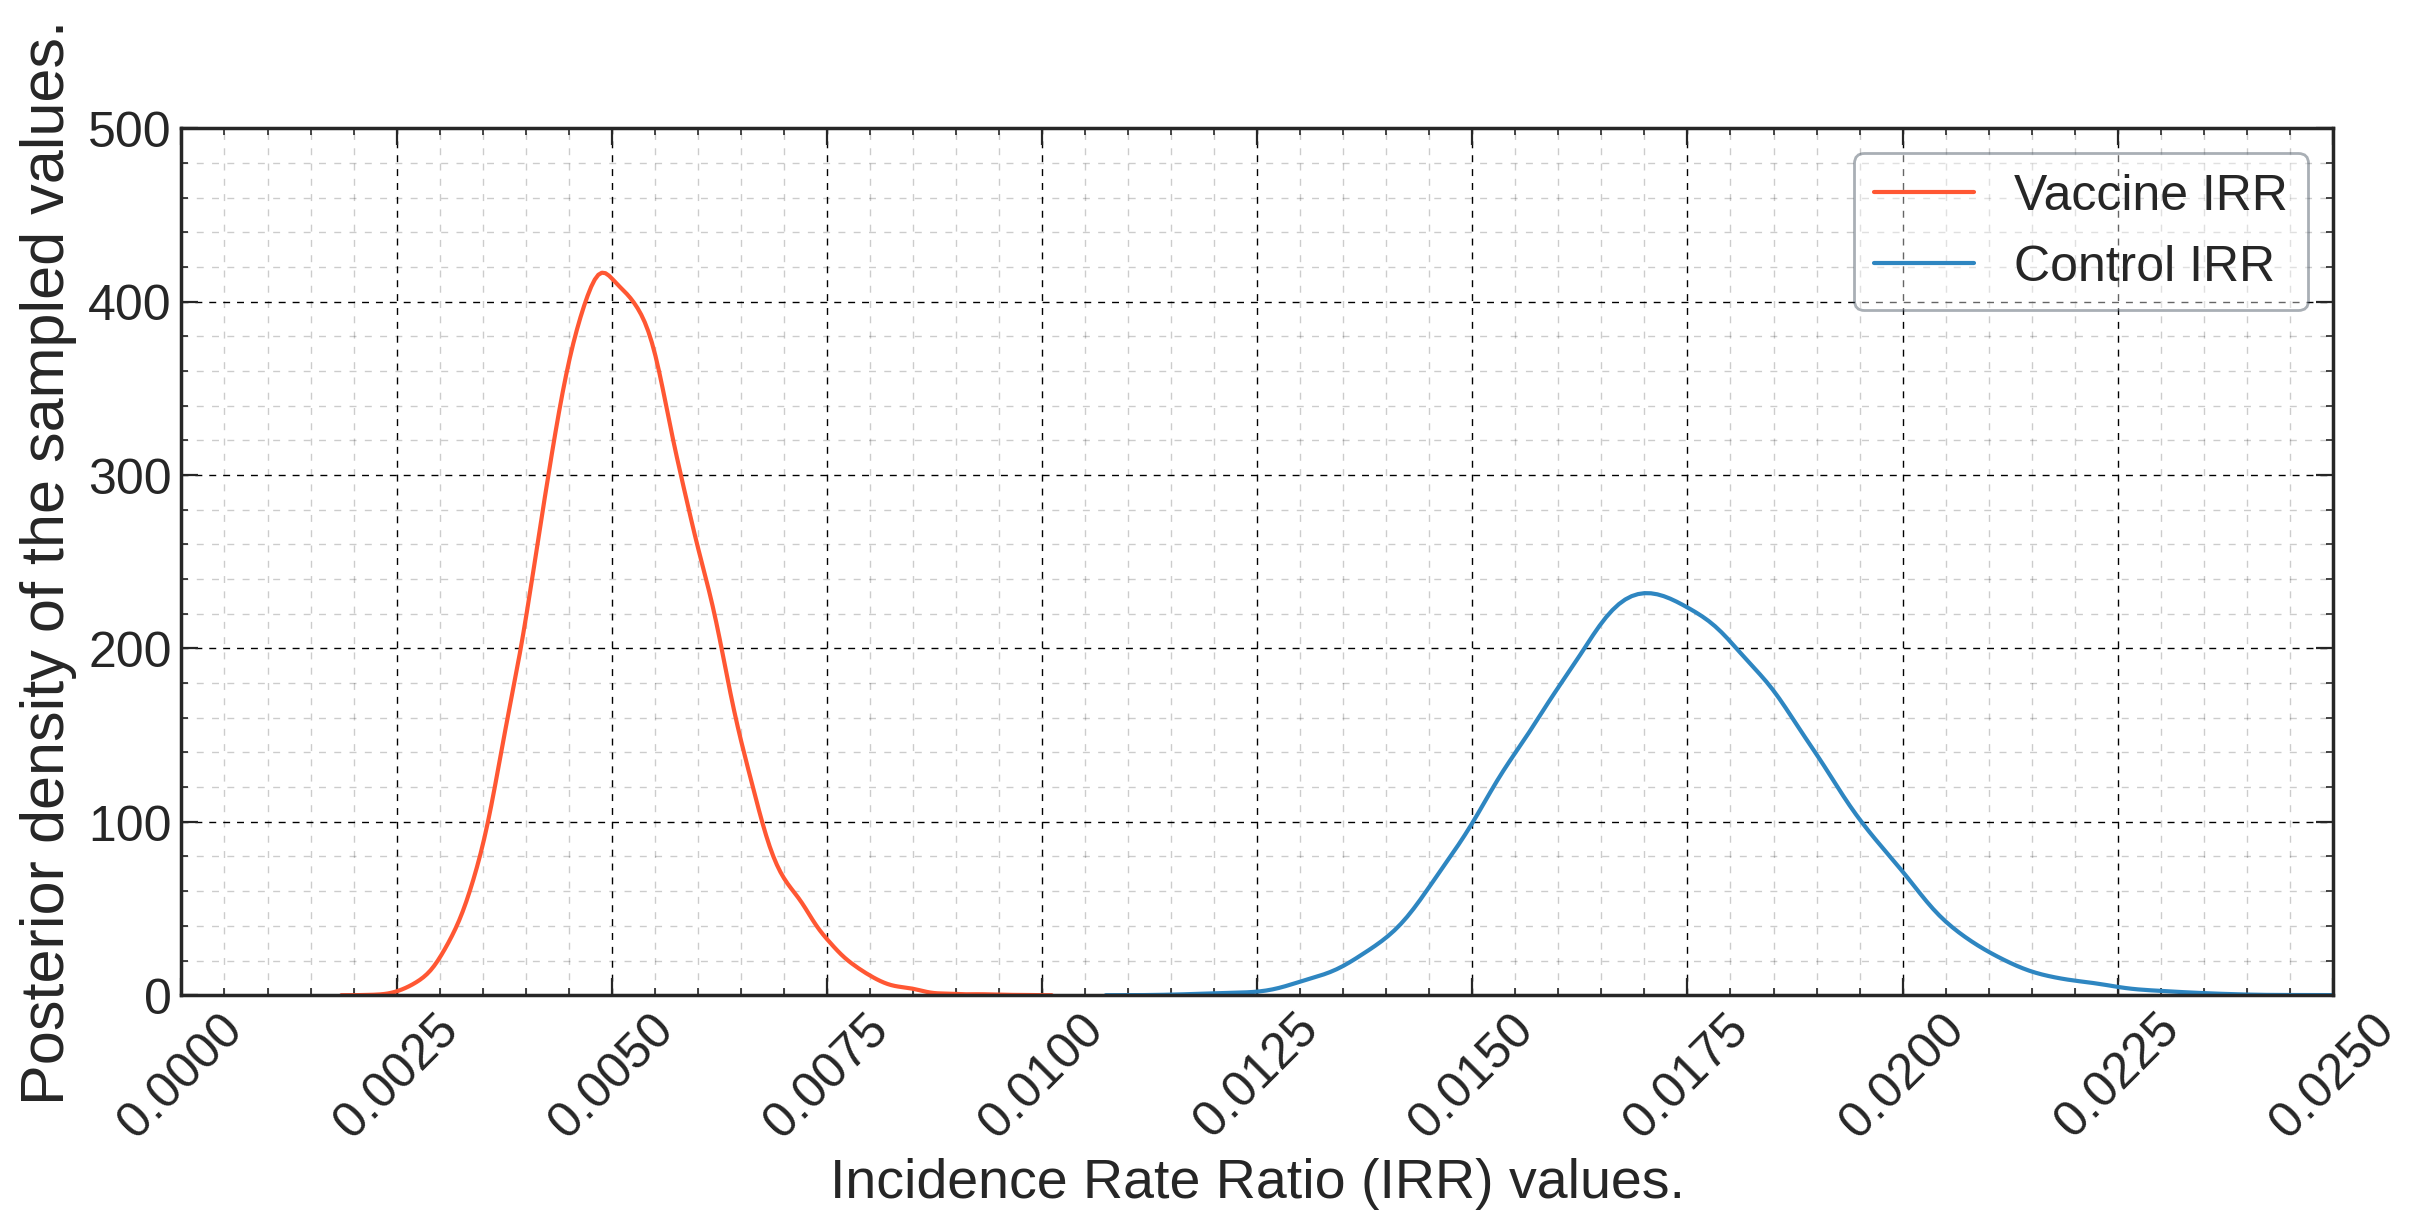

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(v_samples_0, color="#FF5733", label="Vaccine IRR", lw=1.5)
sns.kdeplot(c_samples_0, color="#2E86C1", label="Control IRR", lw=1.5)

# ticks
max = np.floor(v0_kde/100)+1
xticks = np.arange(0, 0.0275, 0.0025)
yticks = np.arange(0, 100*max+1, 100)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=18)
plt.xticks(rotation=45)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 0; xmax = 0.025
ymin = 0; ymax = 100*max
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Incidence Rate Ratio (IRR) values.", fontsize=20)
plt.ylabel("Posterior density of the sampled values.", fontsize=22)

# legend
plt.legend(frameon=True, fontsize=18, framealpha=0.4, edgecolor="#283747")

# plt.savefig("trial1___virr_vs_cirr__ovr.png", dpi=600)
plt.show();

In [ ]:
ve_samples_0 = trace0['ve']
ve0_kde_man = gkde(ve_samples_0)

ci_0_x = mquantiles(ve_samples_0, prob=[0.025, 0.975])
ci_0_y = ve0_kde_man(mquantiles(ve_samples_0, prob=[0.025, 0.975]))

h = 0.005
x_fill_0 = np.arange(ci_0_x[0]+h, ci_0_x[1], h)
y_fill_0 = ve0_kde_man(x_fill_0)

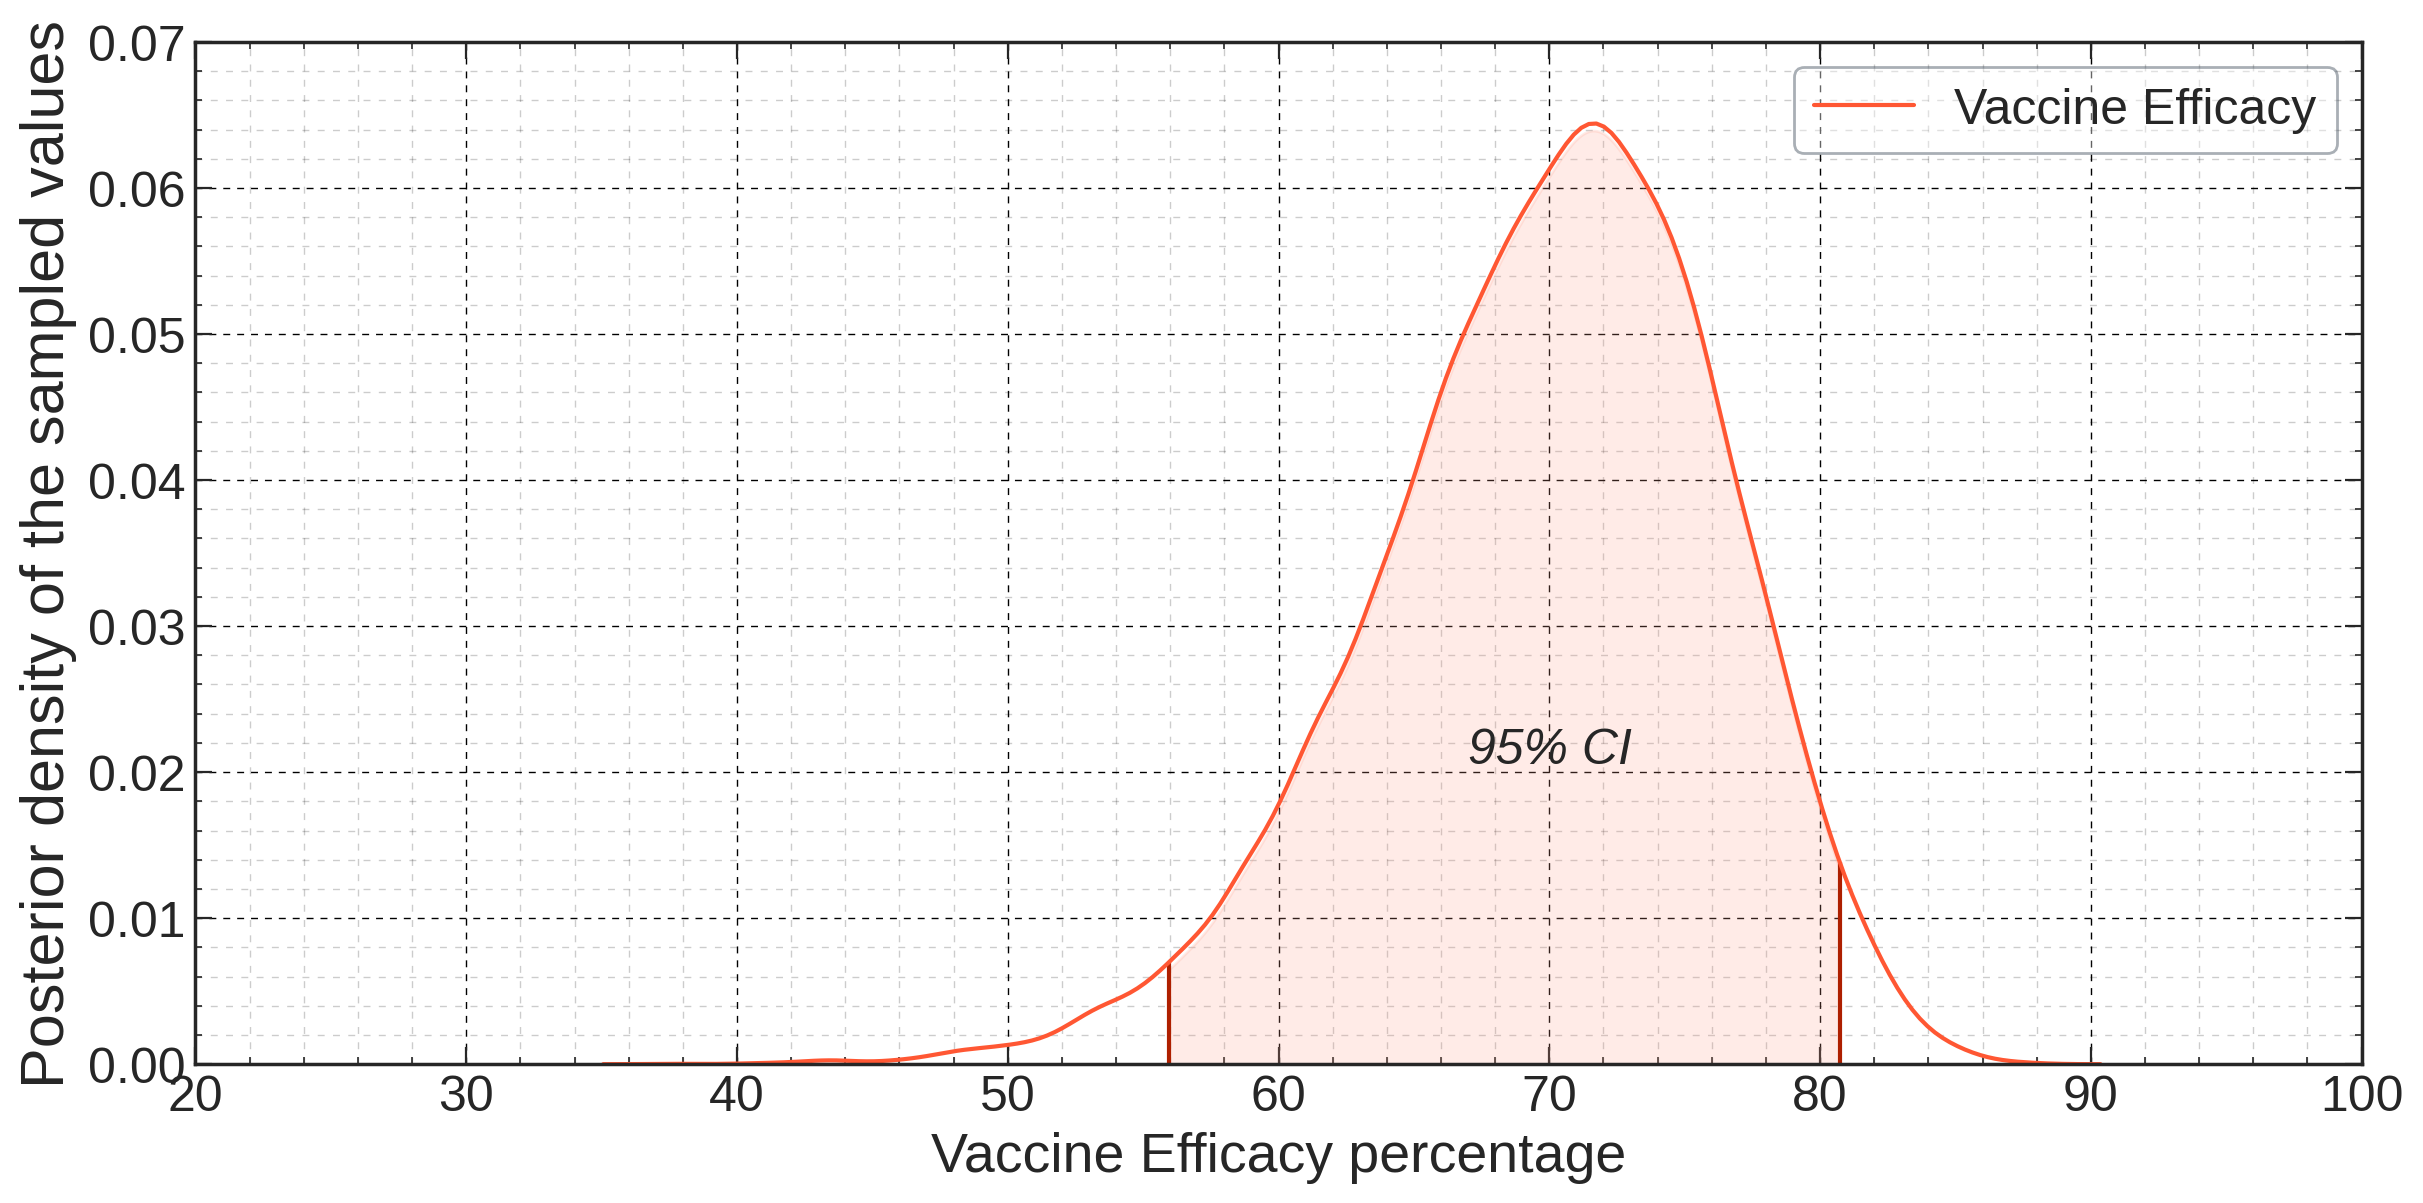

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(ve_samples_0, color="#FF5733", label="Vaccine Efficacy", lw=1.5)

# 95% CI
plt.vlines(ci_0_x, ymin=[0, 0], ymax=ci_0_y, color='#AE1F00')
plt.fill_between(x=x_fill_0, y1=y_fill_0, color="#FF9D88", alpha=0.2)
plt.text(67, 0.0206, "95% CI", style='italic', size=18)

# ticks
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.08, 0.01)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=18)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 20; xmax = 100
ymin = 0; ymax = 0.07
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Vaccine Efficacy percentage", fontsize=20)
plt.ylabel("Posterior density of the sampled values", fontsize=22)

# legend
plt.legend(frameon=True, fontsize=18, framealpha=0.4, edgecolor="#283747")

# plt.savefig("trial1___virr_vs_cirr__ovr.png", dpi=600)
plt.show();

## Analysis over cov group 1

In [ ]:
v_samples_1 = trace1['virr']
c_samples_1 = trace1['cirr']

v1_kde = gkde(v_samples_1)(v_samples_1).max()

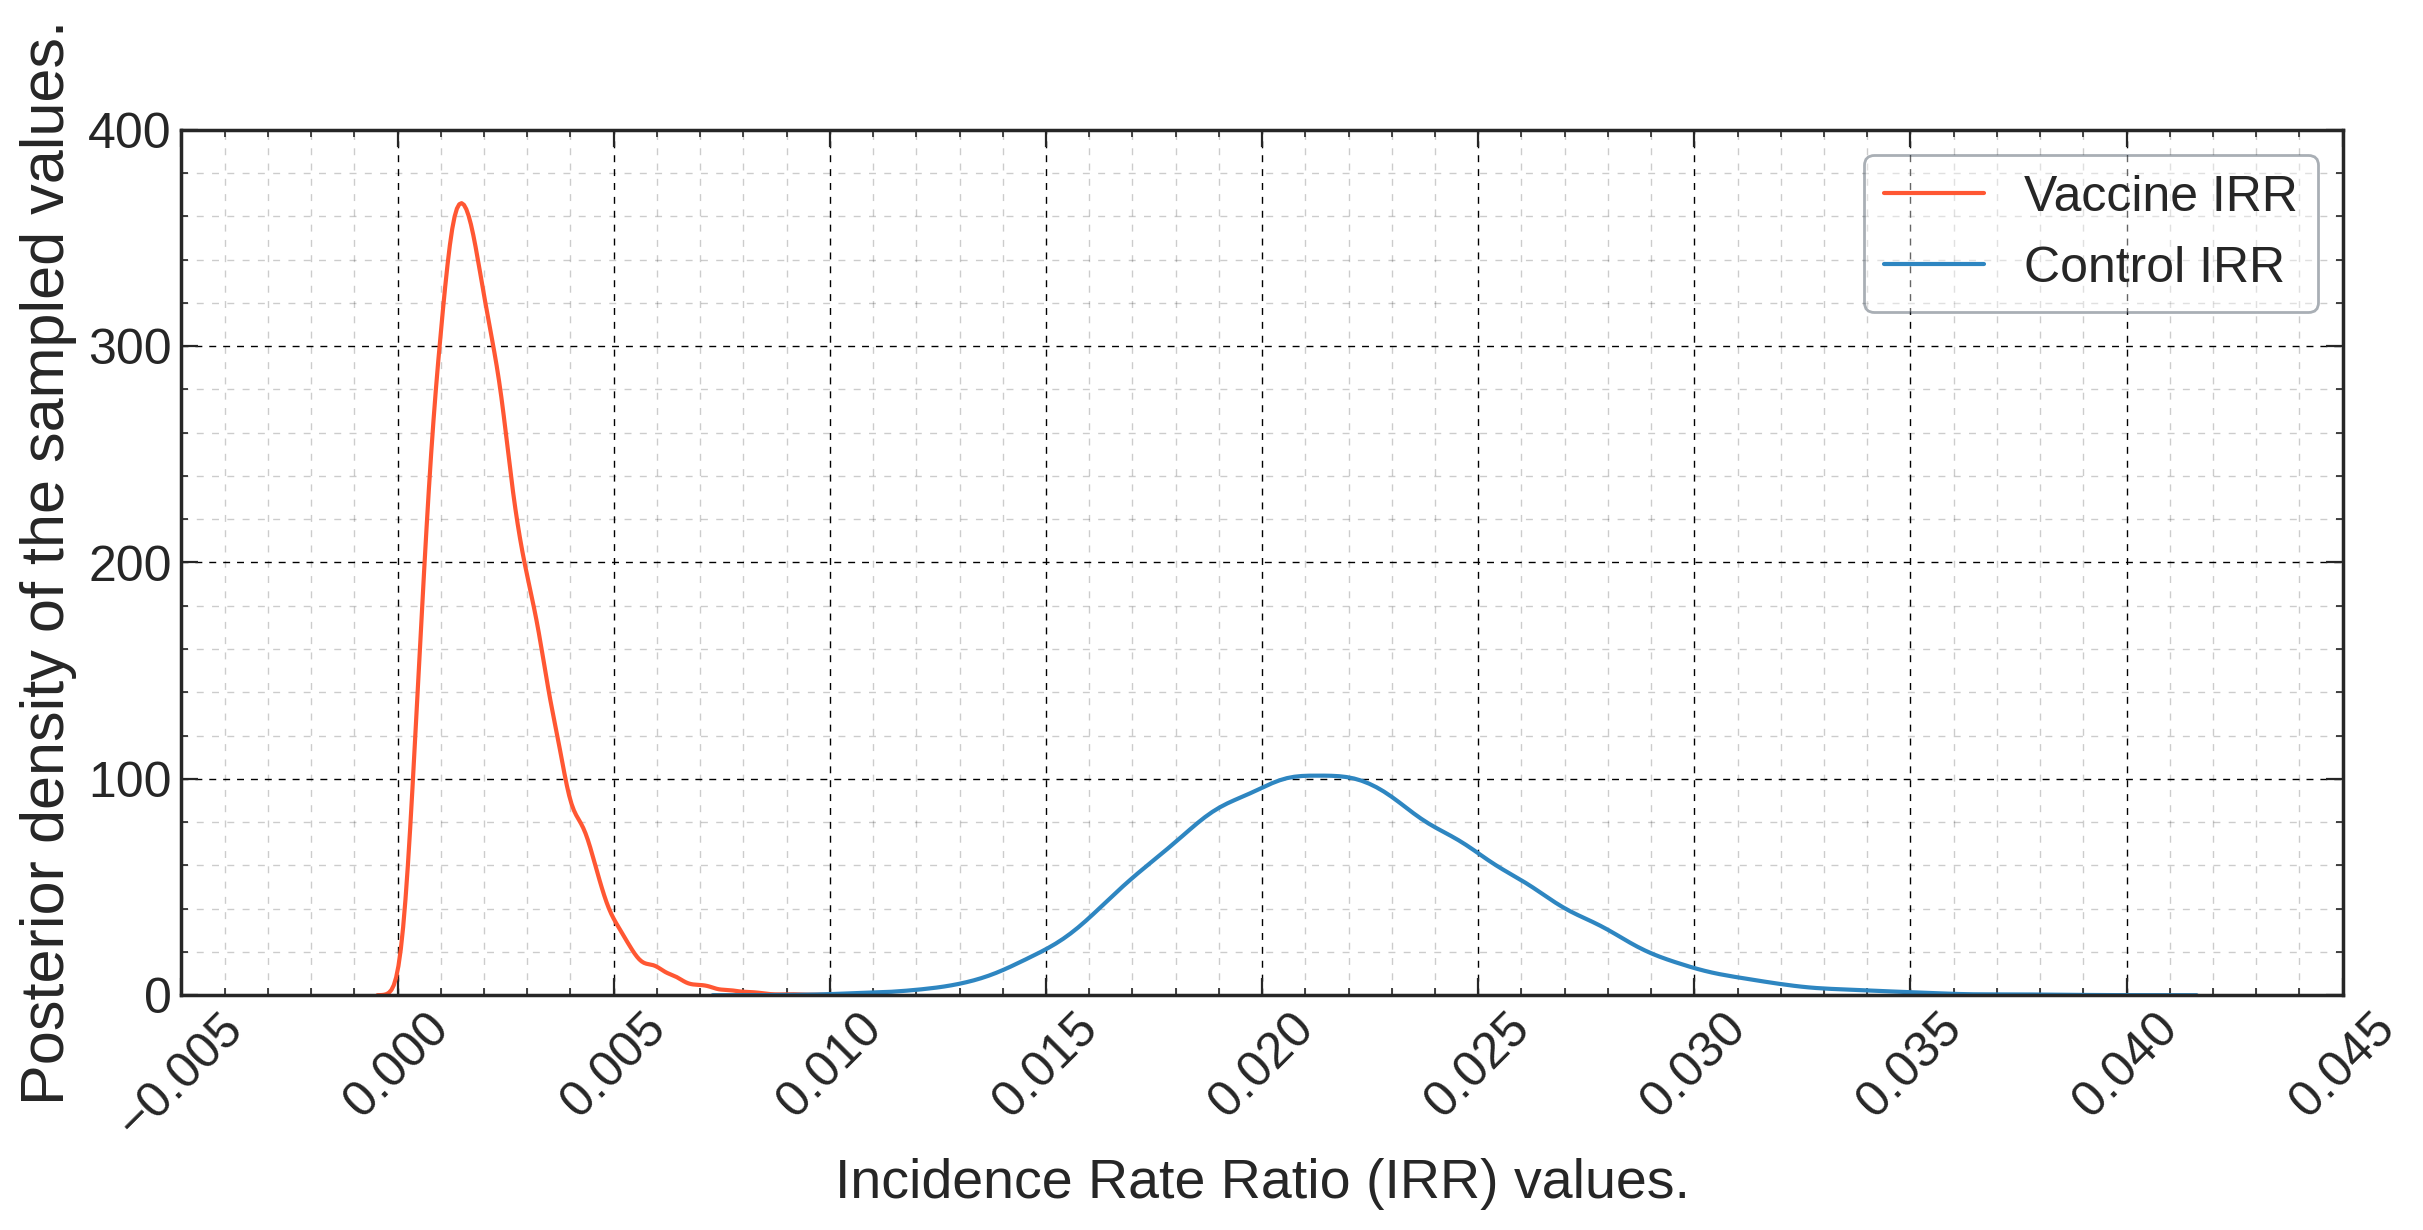

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(v_samples_1, color="#FF5733", label="Vaccine IRR", lw=1.5)
sns.kdeplot(c_samples_1, color="#2E86C1", label="Control IRR", lw=1.5)

# ticks
max = np.floor(v1_kde/100)+1
xticks = np.arange(-0.005, 0.05, 0.005)
yticks = np.arange(0, 100*max+1, 100)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=18)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xticks(rotation=45)


# limits
xmin = -0.005; xmax = 0.045
ymin = 0; ymax = 100*max
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Incidence Rate Ratio (IRR) values.", fontsize=20)
plt.ylabel("Posterior density of the sampled values.", fontsize=22)

# legend
plt.legend(frameon=True, fontsize=18, framealpha=0.4, edgecolor="#283747")

# plt.savefig("trial1___virr_vs_cirr__ovr.png", dpi=600)
plt.show();

In [ ]:
ve_samples_1 = trace1['ve']
ve1_kde_man = gkde(ve_samples_1)

ci_1_x = mquantiles(ve_samples_1, prob=[0.025, 0.975])
ci_1_y = ve1_kde_man(mquantiles(ve_samples_1, prob=[0.025, 0.975]))

h = 0.005
x_fill_1 = np.arange(ci_1_x[0]+h, ci_1_x[1], h)
y_fill_1 = ve1_kde_man(x_fill_1)

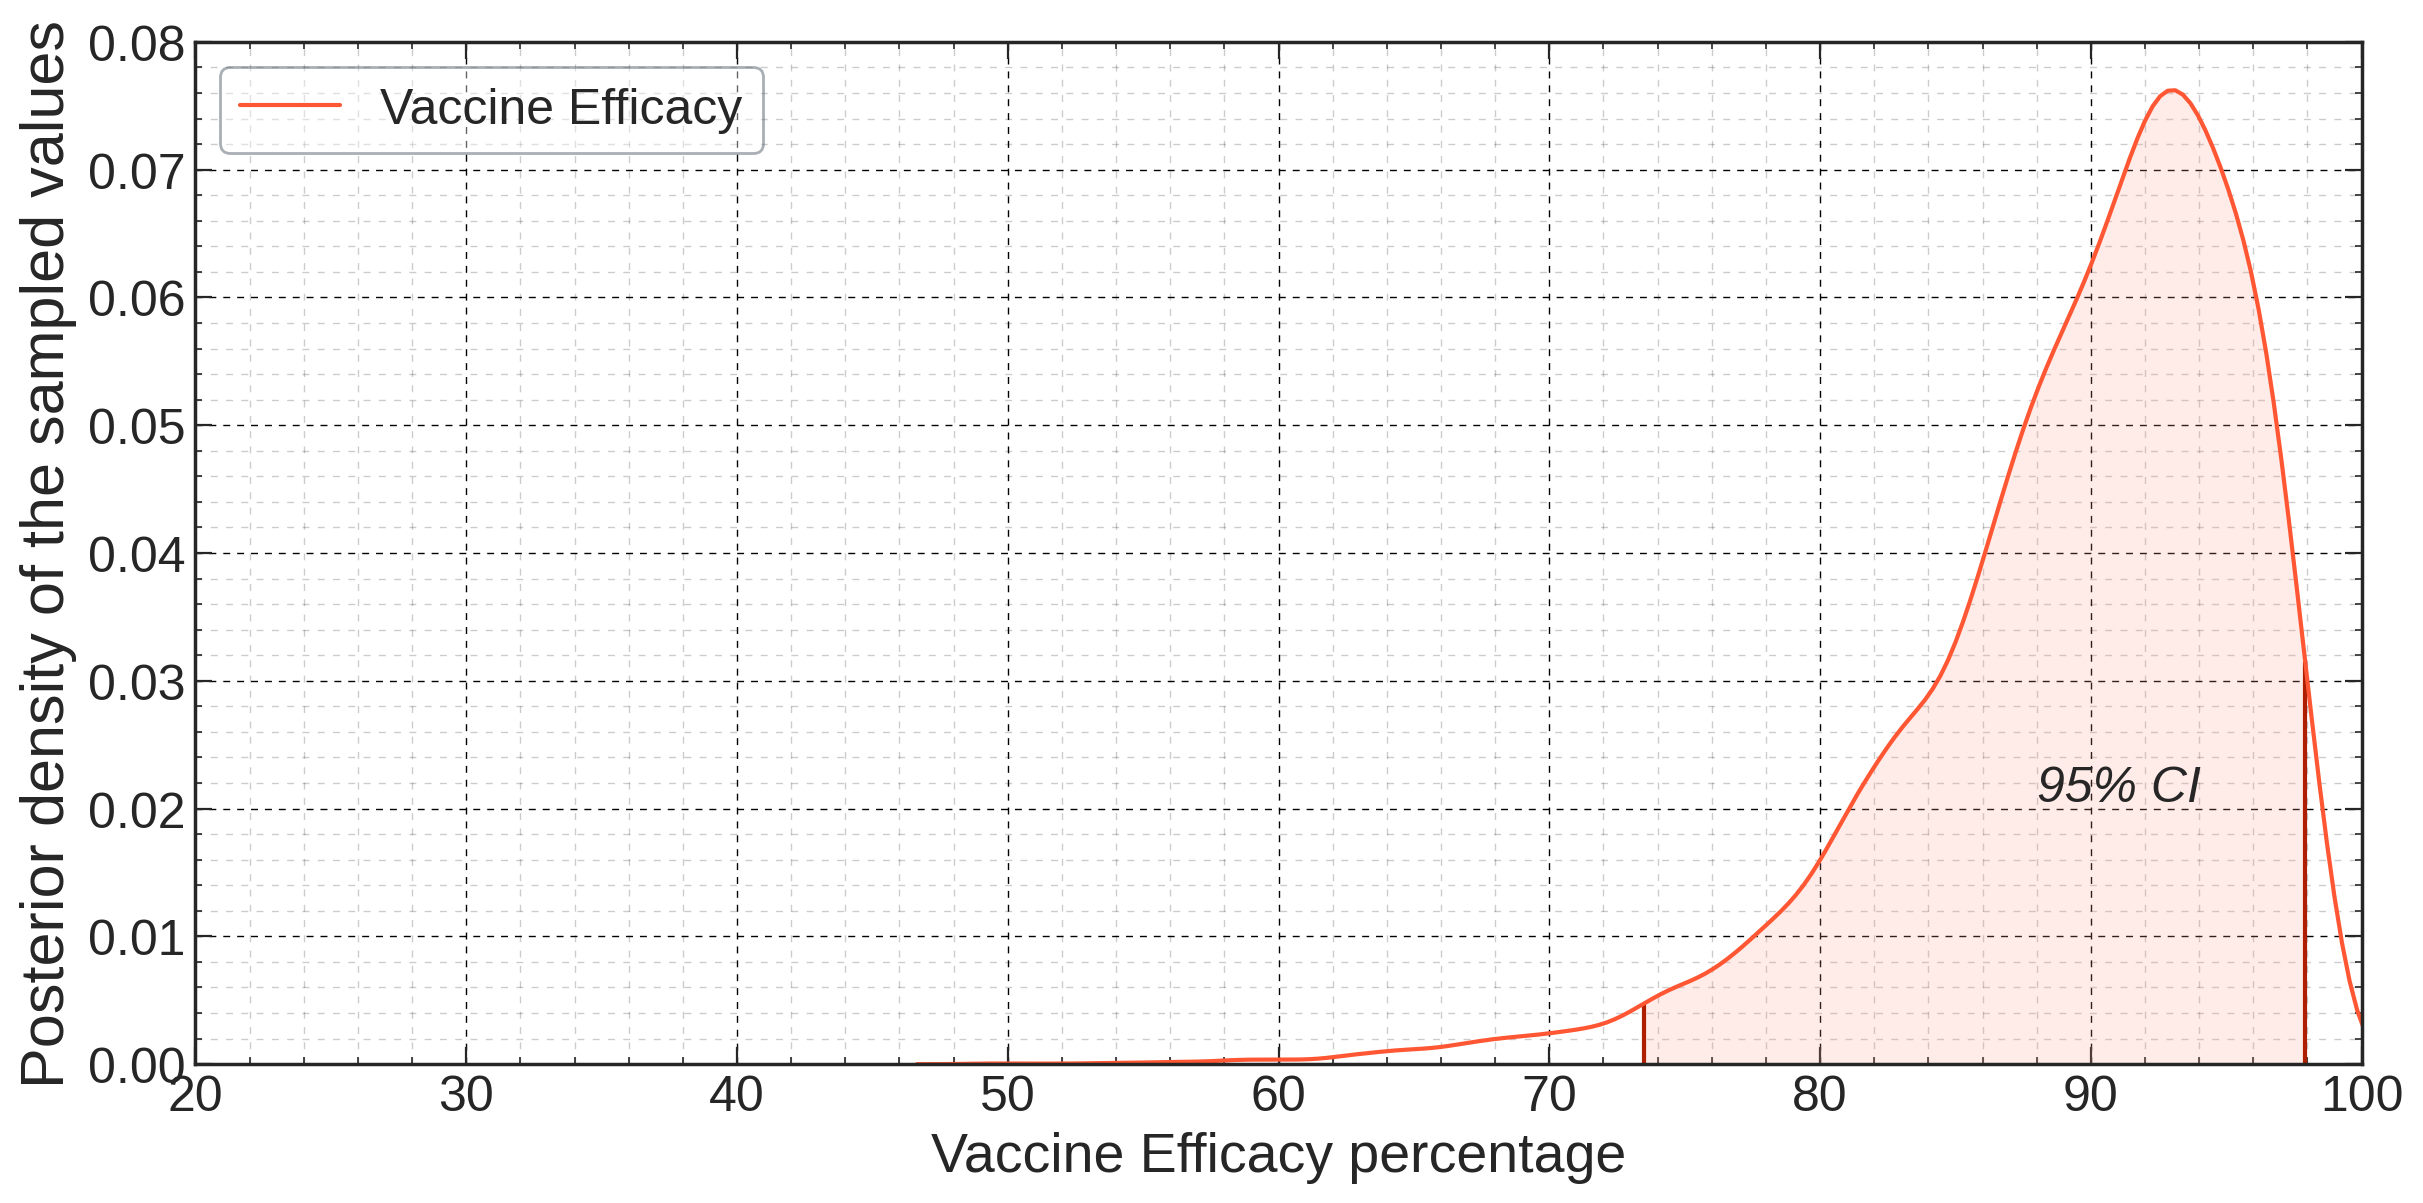

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(ve_samples_1, color="#FF5733", label="Vaccine Efficacy", lw=1.5)

# 95% CI
plt.vlines(ci_1_x, ymin=[0, 0], ymax=ci_1_y, color='#AE1F00')
plt.fill_between(x=x_fill_1, y1=y_fill_1, color="#FF9D88", alpha=0.2)
plt.text(88, 0.0206, "95% CI", style='italic', size=18)

# ticks
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=18)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 20; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Vaccine Efficacy percentage", fontsize=20)
plt.ylabel("Posterior density of the sampled values", fontsize=22)

# legend
plt.legend(frameon=True, fontsize=18, framealpha=0.4, edgecolor="#283747", loc="upper left")

# plt.savefig("trial1___virr_vs_cirr__ovr.png", dpi=600)
plt.show();

# Covishield Data: beta binomial conjugacy scipy

## data calculation

In [ ]:
N = 10000

In [ ]:
# overall
v_samples_0 = stats.beta.rvs(0.010101+30, 1+5807-30, size=N)
c_samples_0 = stats.beta.rvs(0.010101+101, 1+5829-101, size=N)
ve_samples_0 = 100*(1-(v_samples_0/c_samples_0))

# print("Mean ve: ", ve_samples_0.mean())
# print("95% HDI: ", az.stats.hdi(ve_samples_0))
# print("95% CI (i guess): ", mquantiles(ve_samples_0, prob=[0.025, 0.975]))

print(f"VE: {ve_samples_0.mean():.2f} +- {ve_samples_0.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_0, prob=[0.021, 0.979])}")

VE: 69.79 +- 6.29
95% CI: [55.42329637 80.84634831]


In [ ]:
# all LD/SD

v_samples_1 = stats.beta.rvs(0.010101+3, 1+1367-3, size=N)
c_samples_1 = stats.beta.rvs(0.010101+30, 1+1374-30, size=N)
ve_samples_1 = 100*(1-(v_samples_1/c_samples_1))

# print("Mean ve: ", ve_samples_1.mean())
# print("95% HDI: ", az.stats.hdi(ve_samples_1))
# print("95% CI (i guess): ", mquantiles(ve_samples_1, prob=[0.025, 0.975]))


print(f"VE: {ve_samples_1.mean():.2f} +- {ve_samples_1.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_1, prob=[0.025, 0.975])}")

VE: 89.54 +- 6.37
95% CI: [73.56170065 97.95784579]


In [ ]:
# all SD/SD

v_samples_2 = stats.beta.rvs(0.010101+27, 1+4440-27, size=N)
c_samples_2 = stats.beta.rvs(0.010101+71, 1+4455-71, size=N)
ve_samples_2 = 100*(1-(v_samples_2/c_samples_2))

# print("Mean ve: ", ve_samples_2.mean())
# print("95% HDI: ", az.stats.hdi(ve_samples_2))
# print("95% CI (i guess): ", mquantiles(ve_samples_2, prob=[0.025, 0.975]))


print(f"VE: {ve_samples_2.mean():.2f} +- {ve_samples_2.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_2, prob=[0.025, 0.975])}")

VE: 61.36 +- 8.71
95% CI: [42.26115561 76.25853631]


In [ ]:
# cov002_sd/sd

v_samples_3 = stats.beta.rvs(0.010101+15, 1+2377-15, size=N)
c_samples_3 = stats.beta.rvs(0.010101+38, 1+2430-38, size=N)
ve_samples_3 = 100*(1-(v_samples_3/c_samples_3))

# print("Mean ve: ", ve_samples_2.mean())
# print("95% HDI: ", az.stats.hdi(ve_samples_2))
# print("95% CI (i guess): ", mquantiles(ve_samples_2, prob=[0.025, 0.975]))


print(f"VE: {ve_samples_3.mean():.2f} +- {ve_samples_3.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_3, prob=[0.025, 0.975])}")

VE: 58.56 +- 12.82
95% CI: [28.60560025 78.58498899]


In [ ]:
# cov003_sd/sd

v_samples_3 = stats.beta.rvs(0.010101+12, 1+2063-12, size=N)
c_samples_3 = stats.beta.rvs(0.010101+33, 1+2025-33, size=N)
ve_samples_3 = 100*(1-(v_samples_3/c_samples_3))

# print("Mean ve: ", ve_samples_2.mean())
# print("95% HDI: ", az.stats.hdi(ve_samples_2))
# print("95% CI (i guess): ", mquantiles(ve_samples_2, prob=[0.025, 0.975]))


print(f"VE: {ve_samples_3.mean():.2f} +- {ve_samples_3.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_3, prob=[0.025, 0.975])}")

VE: 63.27 +- 12.65
95% CI: [33.37331731 82.36442184]


In [ ]:
# cov002_all

v_samples_3 = stats.beta.rvs(0.010101+18, 1+3744-18, size=N)
c_samples_3 = stats.beta.rvs(0.010101+68, 1+3804-68, size=N)
ve_samples_3 = 100*(1-(v_samples_3/c_samples_3))

# print("Mean ve: ", ve_samples_2.mean())
# print("95% HDI: ", az.stats.hdi(ve_samples_2))
# print("95% CI (i guess): ", mquantiles(ve_samples_2, prob=[0.025, 0.975]))


print(f"VE: {ve_samples_3.mean():.2f} +- {ve_samples_3.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_3, prob=[0.025, 0.975])}")

VE: 72.82 +- 7.17
95% CI: [57.02689464 84.67911921]


## Analysis over entire

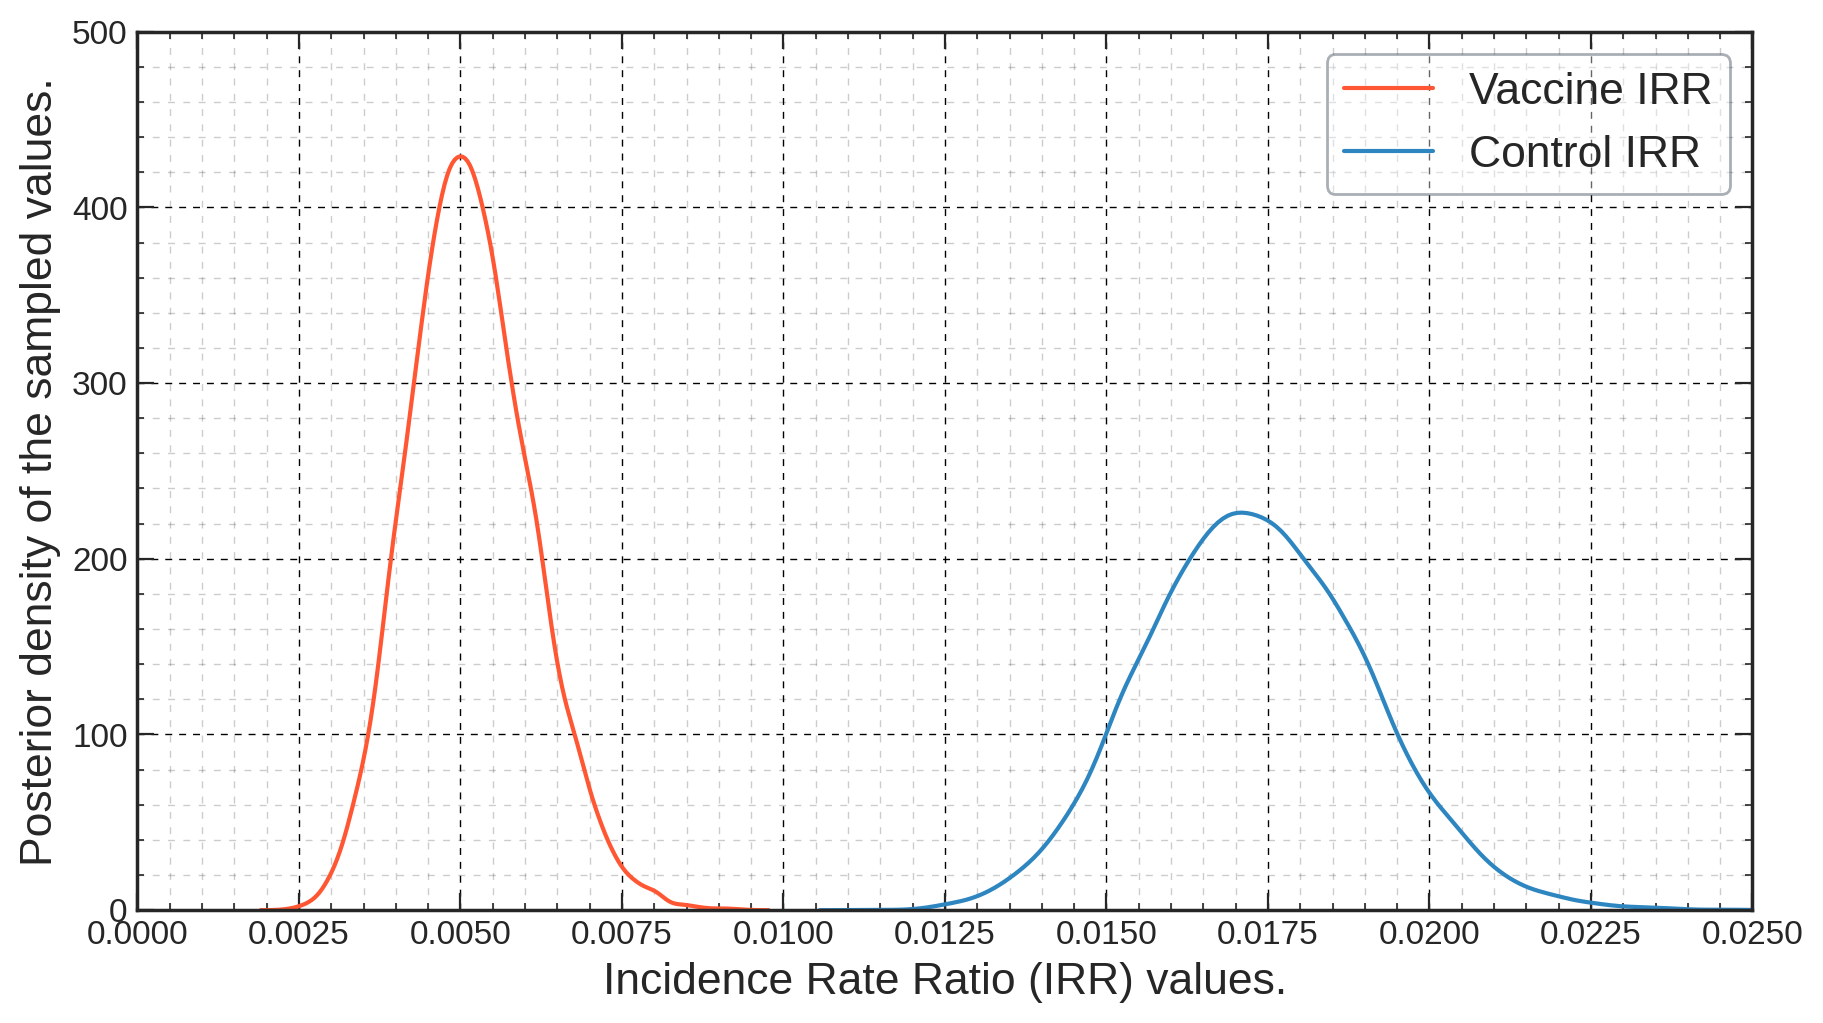

In [ ]:
fig = plt.figure(1, figsize=(9, 5))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(v_samples_0, color="#FF5733", label="Vaccine IRR", lw=1.5)
sns.kdeplot(c_samples_0, color="#2E86C1", label="Control IRR", lw=1.5)

# ticks
max = 5
xticks = np.arange(0, 0.0275, 0.0025)
yticks = np.arange(0, 100*max+1, 100)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=12)
plt.xticks(rotation=0)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 0; xmax = 0.025
ymin = 0; ymax = 100*max
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Incidence Rate Ratio (IRR) values.", fontsize=16)
plt.ylabel("Posterior density of the sampled values.", fontsize=16)

# legend
plt.legend(frameon=True, fontsize=16, framealpha=0.4, edgecolor="#283747")

# plt.savefig("trial1___virr_vs_cirr__ovr.png", dpi=600)
plt.show();

In [ ]:
ve0_kde_man = gkde(ve_samples_0)

ci_0_x = mquantiles(ve_samples_0, prob=[0.025, 0.975])
ci_0_y = ve0_kde_man(mquantiles(ve_samples_0, prob=[0.025, 0.975]))

h = 0.005
x_fill_0 = np.arange(ci_0_x[0]+h, ci_0_x[1], h)
y_fill_0 = ve0_kde_man(x_fill_0)

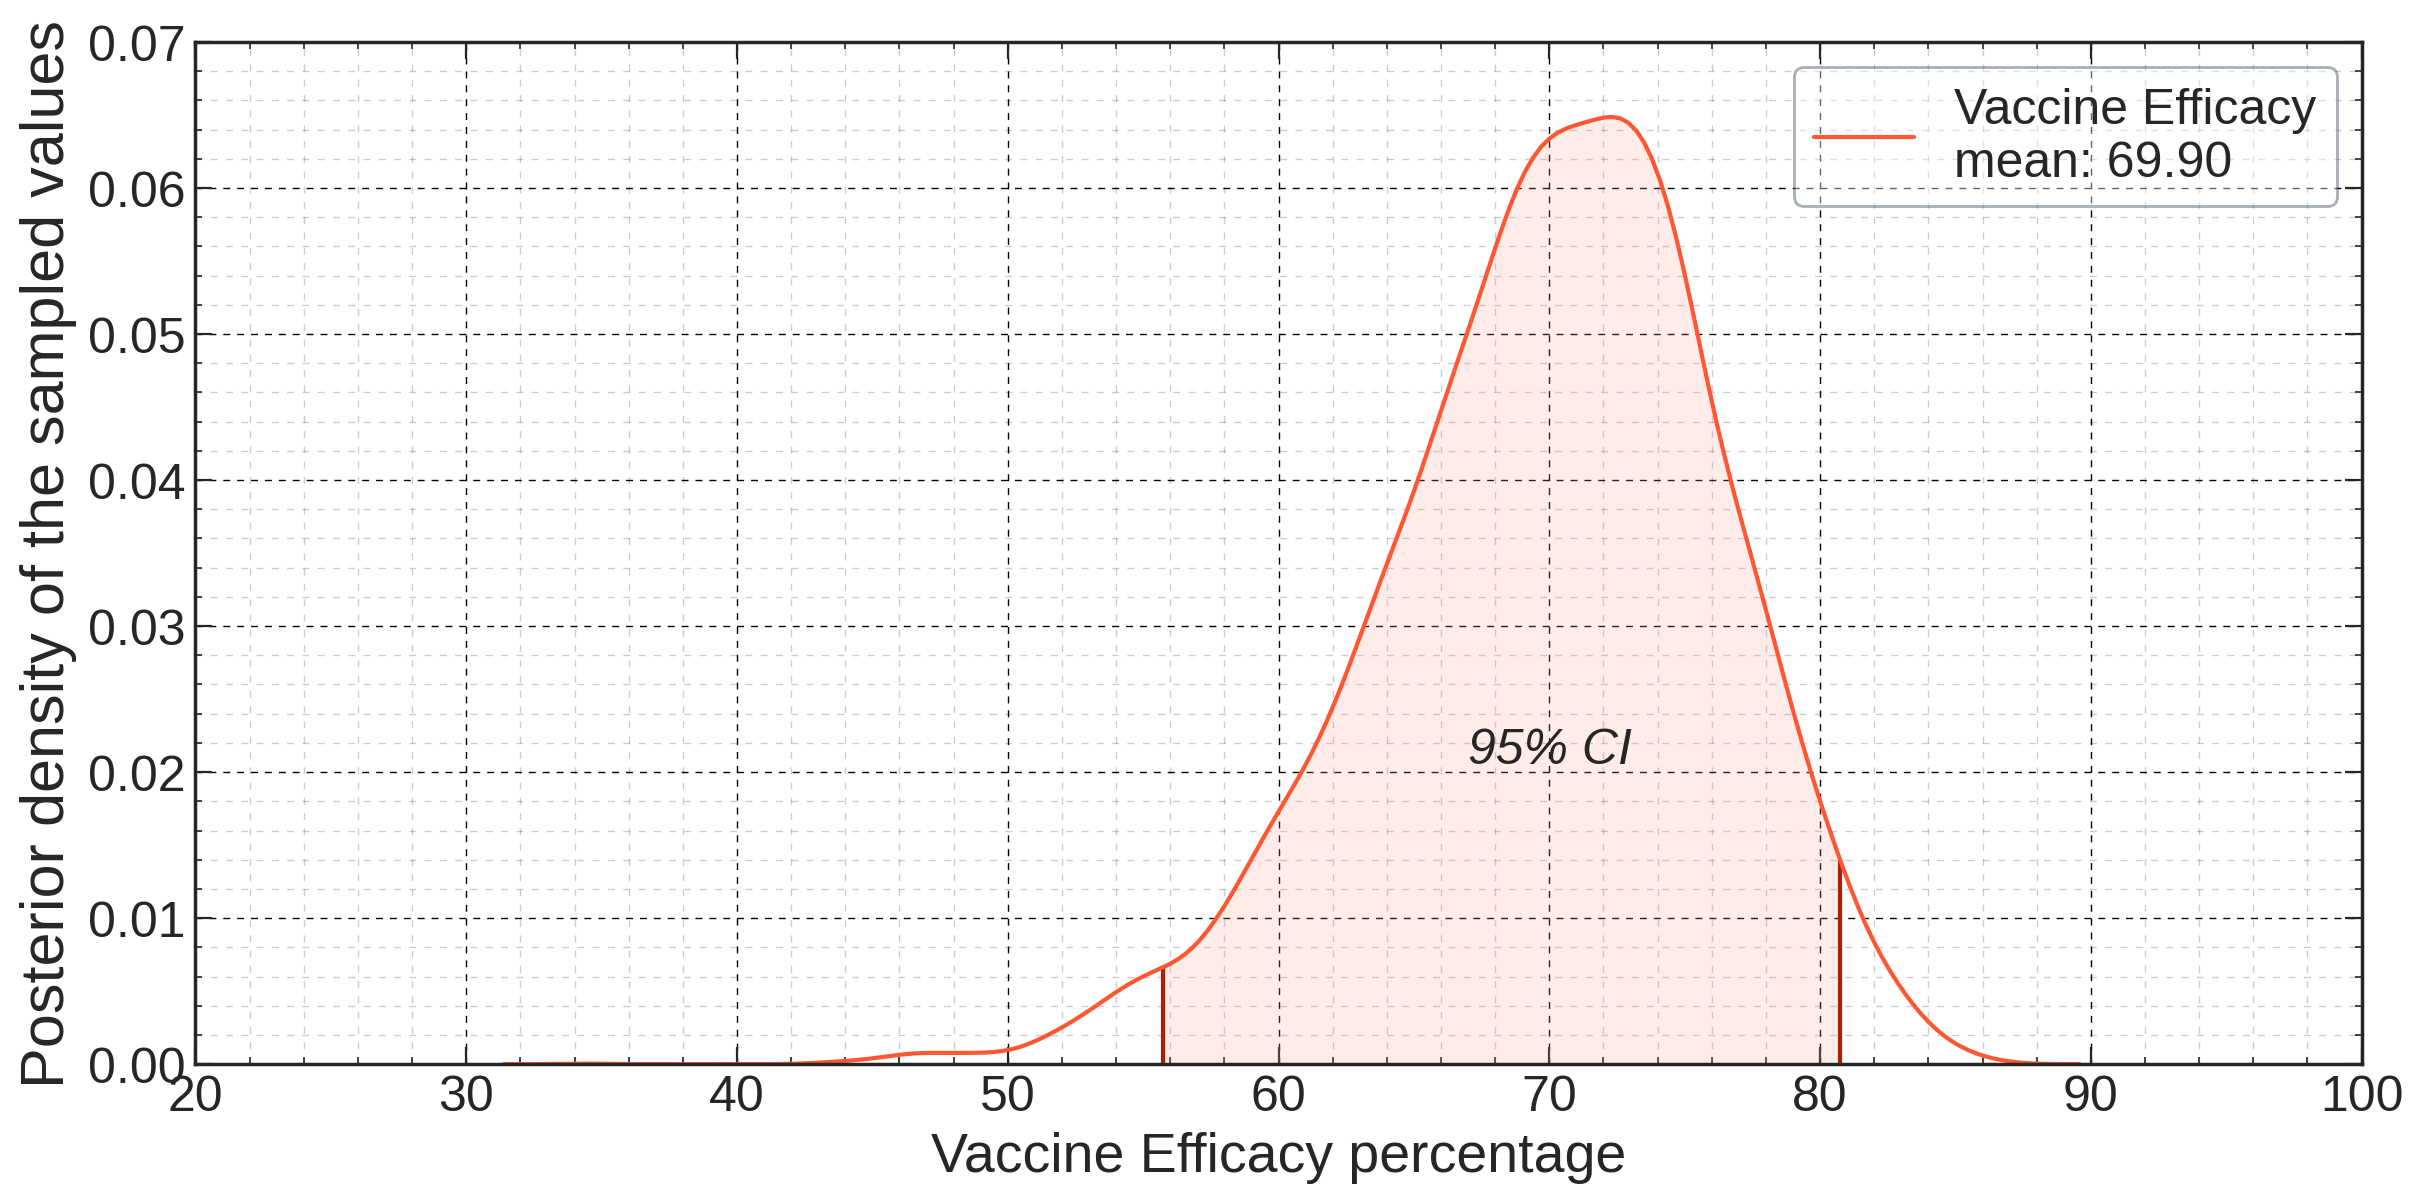

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(ve_samples_0, color="#FF5733", label=f"Vaccine Efficacy\nmean: {ve_samples_0.mean():.2f}", lw=1.5)

# 95% CI
plt.vlines(ci_0_x, ymin=[0, 0], ymax=ci_0_y, color='#AE1F00')
plt.fill_between(x=x_fill_0, y1=y_fill_0, color="#FF9D88", alpha=0.2)
plt.text(67, 0.0206, "95% CI", style='italic', size=18)

# ticks
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.08, 0.01)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=18)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 20; xmax = 100
ymin = 0; ymax = 0.07
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Vaccine Efficacy percentage", fontsize=20)
plt.ylabel("Posterior density of the sampled values", fontsize=22)

# legend
plt.legend(frameon=True, fontsize=18, framealpha=0.4, edgecolor="#283747")

# plt.savefig("trial1___virr_vs_cirr__ovr.png", dpi=600)
plt.show();

## entries to be shown

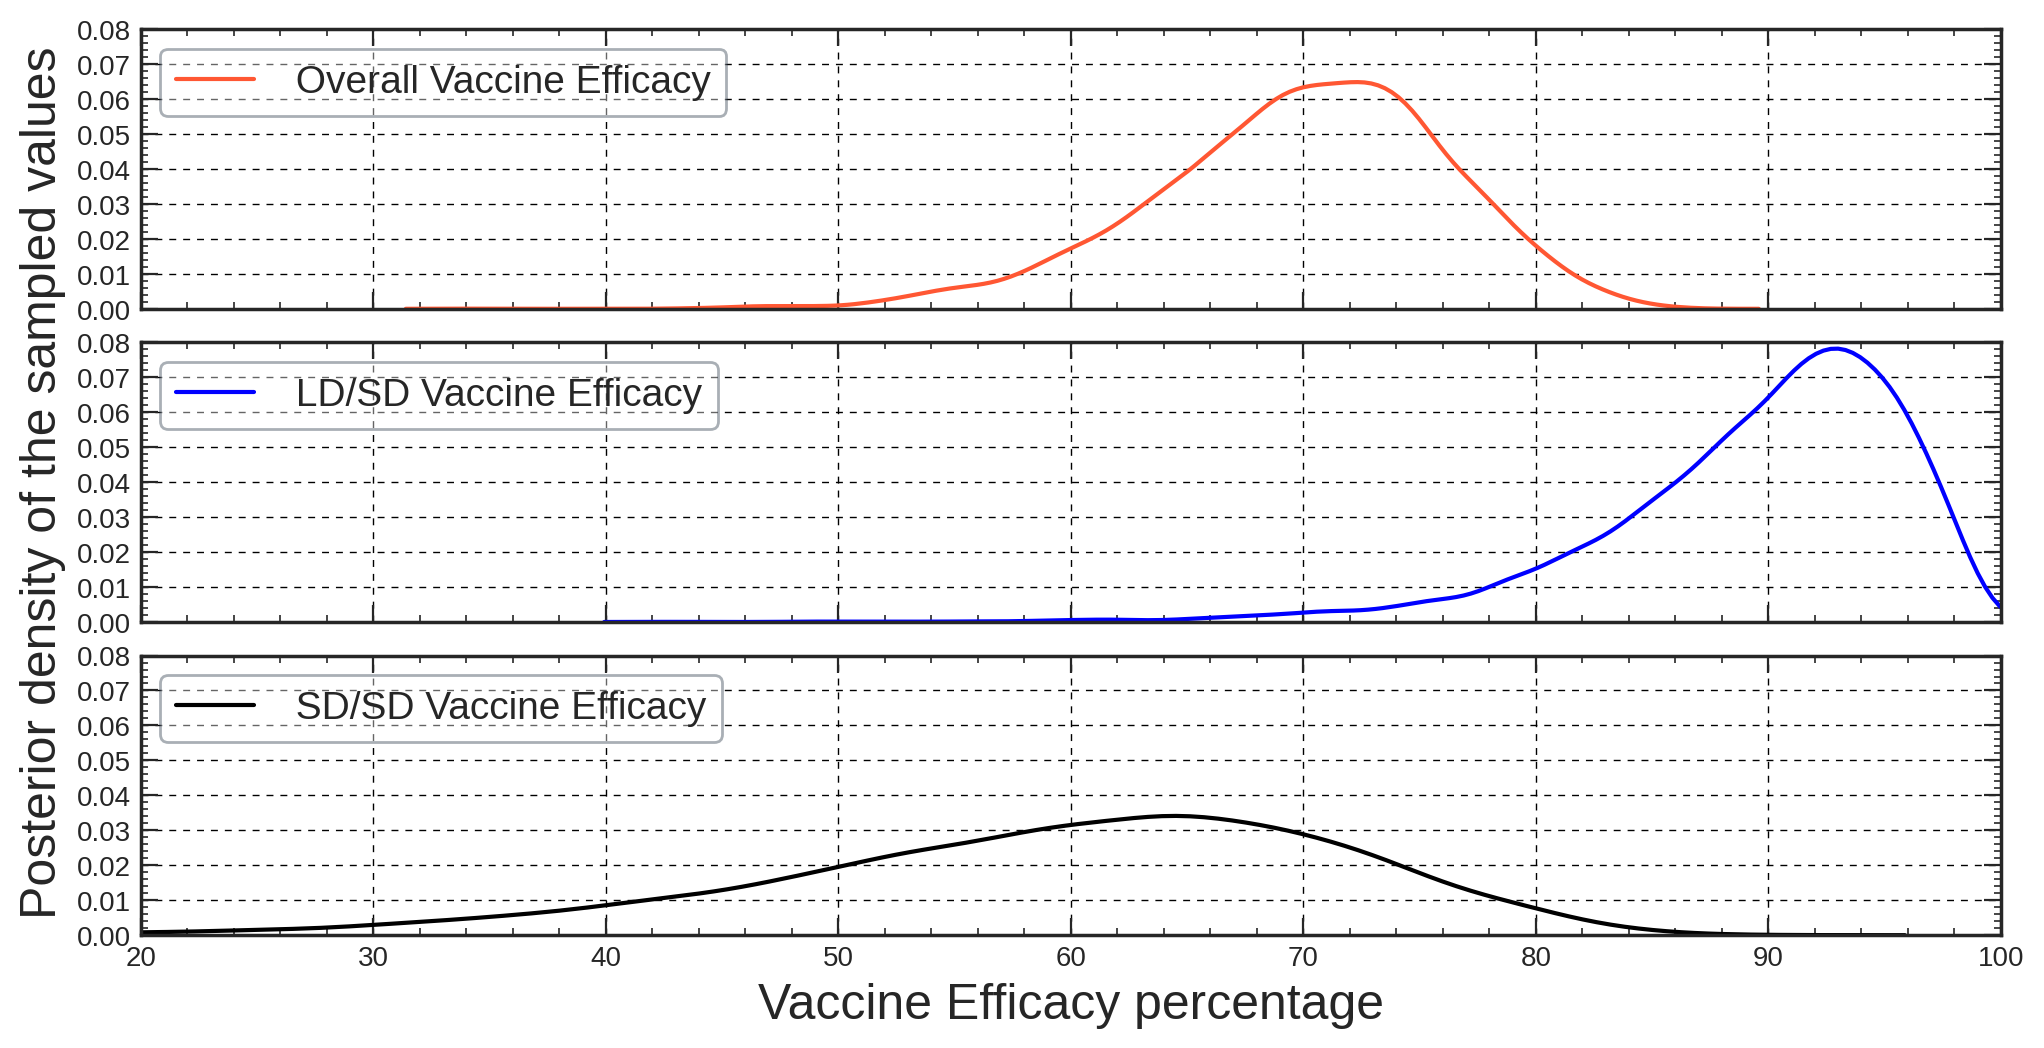

In [ ]:
fig = plt.figure(2, figsize=(12, 6))
gs = gridspec.GridSpec(12, 12)
gs.update(wspace=0.2, hspace=0.75)
# plt.axes(frameon=True)

# overall
xtr_subsplot= fig.add_subplot(gs[0:4,0:12])
sns.kdeplot(ve_samples_0, color="#FF5733", label=" Overall Vaccine Efficacy", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 20; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ")

# LD/SD
xtr_subsplot= fig.add_subplot(gs[4:8,0:12])
sns.kdeplot(ve_samples_1, color="blue", label=" LD/SD Vaccine Efficacy", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 20; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel("Posterior density of the sampled values", fontsize=18)

# SD/SD
xtr_subsplot= fig.add_subplot(gs[8:12,0:12])
sns.kdeplot(ve_samples_2, color="black", label=" SD/SD Vaccine Efficacy", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=True, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 20; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747", loc="upper left")
plt.ylabel(" ")


plt.xlabel("Vaccine Efficacy percentage", fontsize=18)
# plt.ylabel("Posterior density of the sampled values", fontsize=22)
plt.show();